# Anomaly detection

**异常检测的基本原理如下**

![anomaly detection](./Image/anomaly detection.png)

**异常检测与普通监督模型之间的对比**
![compare2](./Image/compare2.png)
**具体的算法如下**
* **使用普通的高斯分布来进行数据的密度估计**
![normal gaussion](./Image/normal gaussion.png)
* **使用多元高斯模型来进行异常检测**
![multi gaussion](./Image/multi gaussion.png)
* **两种模型的对比**
![compare1](./Image/compare1.png)
* **特征的选择**

异常检测假设特征符合高斯分布，如果数据的分布不满足高斯分布，异常检测算法仍然可以工作，但是最好还是转换为高斯分布，比如使用对数函数x=log(x+c)或者x=x^c的方式。

**异常检测中数据的分配以及评价方法**

* **数据分配**

例如：我们有10000台正常引擎的数据，有20台异常引擎的数据。 我们这样分配数据：

6000台正常引擎的数据作为训练集

2000台正常引擎和10台异常引擎的数据作为交叉检验集

2000台正常引擎和10台异常引擎的数据作为测试集

* **评价方法**


1. 根据测试集数据，我们估计特征的平均值和方差并构建p(x)函数


2. 对交叉检验集，我们尝试使用不同的el值作为阀值，并预测数据是否异常，根据F1值或者查准率与查全率的比例来选择 el


3. 选出el后，针对测试集进行预测，计算异常检验系统的F1值，或者查准率与查全率之比

# 异常检测练习

## 导入数据并可视化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sb
from scipy.io import loadmat

In [3]:
data = loadmat('data/ex8data1.mat')
print(data.keys())
X = data['X']
X.shape

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


(307, 2)

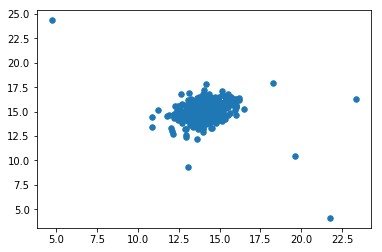

In [4]:
plt.scatter(X[:,0],X[:,1],s=30)
plt.show()

## 构建异常检测算法
**定义计算数据高斯分布参数的函数**

In [5]:
def estimate_gaussion(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    return mu,sigma

In [7]:
mu,sigma = estimate_gaussion(X)
mu,sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

**确定概率阈值**

现在我们有了我们的模型参数，我们需要确定概率阈值，这表明一个样本应该被认为是一个异常。 为此，我们需要使用一组标记的验证数据（其中真实异常样本已被标记），并在给出不同阈值的情况下，对模型的性能进行鉴定。

In [8]:
Xval = data['Xval']
yval = data['yval']
Xval.shape,yval.shape

((307, 2), (307, 1))

我们还需要一种计算数据点属于正态分布的概率的方法。 幸运的是SciPy有这个内置的方法。

In [21]:
from scipy import stats
dist0 = stats.norm(mu[0],sigma[0])
dist1 = stats.norm(mu[1],sigma[1])

p = np.zeros(X.shape)
p[:,0] = dist0.pdf(X[:,0])
p[:,1] = dist1.pdf(X[:,1])

pAll = p[:,0]*p[:,1]
p.shape,pAll.shape

((307, 2), (307,))

In [24]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pvalAll = pval[:,0]*pval[:,1]
pval.shape,pvalAll.shape,yval.shape

((307, 2), (307,), (307, 1))

接下来，我们需要一个函数，找到给定概率密度值和真实标签的最佳阈值。 为了做到这一点，我们将为不同的epsilon值计算F1分数。 F1是真阳性，假阳性和假阴性的数量的函数。

**采用的方法是只要一个特征小于阈值，则就被认定为异常，而不是对所有特征概率的乘积来判断**

In [26]:
def select_threshold(pval,yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max()-pval.min())/1000
    #step = (pvalAll.max()-pvalAll.min())/1000
    for epsilon in np.arange(pval.min(),pval.max(),step):
    #for epsilon in np.arange(pvalAll.min(),pvalAll.max(),step):
        preds = pval < epsilon  #小于表示异常 表示为真 1 
        #preds = pvalAll < epsilon
       
        tp = np.sum(np.logical_and(preds==1,yval==1)).astype(float)
        fp = np.sum(np.logical_and(preds==1,yval==0)).astype(float)
        fn = np.sum(np.logical_and(preds==0,yval==1)).astype(float)
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = (2*precision*recall)/(precision+recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
        
    return best_epsilon,best_f1

In [27]:
pesilon,f1 = select_threshold(pval,yval)
#pesilon,f1 = select_threshold(pvalAll,yval)
pesilon,f1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


(0.009566706005956842, 0.7142857142857143)

**使用选定的阈值，应用与训练数据集，并可视化结果**

In [18]:
outliers = np.where(p<pesilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

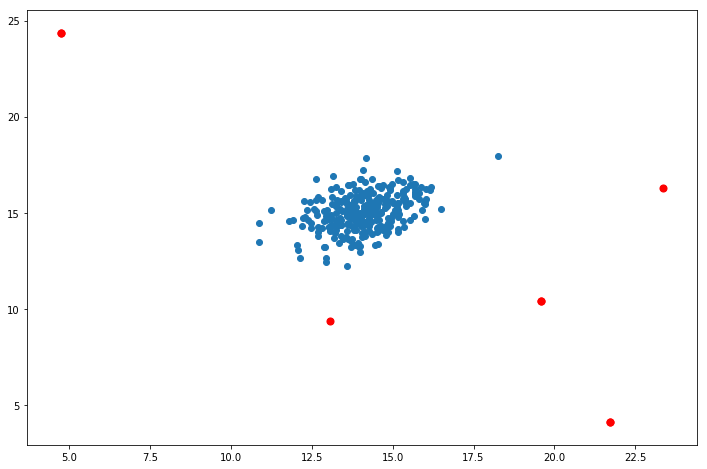

In [28]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()

# 协同过滤
## 协同过滤基本原理（推荐系统）

![recom](./Image/recom.png)

**对于推荐系统，我们针对每一个用户，均学习一套参数**

![recomlarn1](./Image/recomlearn1.png)

![recomlarn2](./Image/recomlearn2.png)

**协同过滤的步骤如下：
![recomlarn3](./Image/recomlearn3.png)

![apply.png](./Image/apply.png)

**实际使用的细节：**

首先对结果Y矩阵进行归一化处理，然后使用这个新的Y来训练算法，预测时候在加上减去的均值。
![apply2](./Image/apply2.png)

## 协同过滤使用练习
### 数据导入

% Notes: X - num_movies (1682)  x num_features (10) matrix of movie features  
%        Theta - num_users (943)  x num_features (10) matrix of user features  
%        Y - num_movies x num_users matrix of user ratings of movies  
%        R - num_movies x num_users matrix, where R(i, j) = 1 if the  i-th movie was rated by the j-th user  

In [32]:
movies_mat = loadmat('data/ex8_movies.mat')
Y,R = movies_mat.get('Y'),movies_mat.get('R')
Y.shape,R.shape
m,u = Y.shape # movie no and user no
n= 10 # feature no

In [34]:
param_mat = loadmat('data/ex8_movieParams.mat')
theta, X = param_mat.get('Theta'), param_mat.get('X')
theta.shape, X.shape

((943, 10), (1682, 10))

### 构建训练所需的函数 
**代价函数**

**注意我们在实现的时候，是通过将特征以及参数合并为params后同时进行训练的，而不是交替训练特征和参数**
![cost](./Image/cost.png)

In [35]:
def serialize(X, theta):
    """serialize 2 matrix
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))

def deserialize(param, n_movie, n_user, n_features):
    """into ndarray of X(1682, 10), theta(943, 10)"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), \
           param[n_movie * n_features:].reshape(n_user, n_features)


# recommendation fn 给定thea以及X后根据Y及R计算代价函数
def cost(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)

    return np.power(inner, 2).sum() / 2

# 保证矩阵维度正确
def gradient(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)

    # X_grad (1682, 10)
    X_grad = inner @ theta

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    return serialize(X_grad, theta_grad)

def regularized_cost(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)

    return cost(param, Y, R, n_features) + reg_term


def regularized_gradient(param, Y, R, n_features, l=1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param

    return grad + reg_term

In [36]:
# use subset of data to calculate the cost as in pdf...
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)
cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [37]:
param = serialize(X, theta)  # total real params

cost(serialize(X, theta), Y, R, 10)  # this is real total cost

27918.64012454421

In [38]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),
                                      n_movie, n_user, 10)

In [39]:
assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

In [40]:
# in the ex8_confi.m, lambda = 1.5, and it's using sub data set
regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [41]:
regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

In [43]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

In [44]:
movie_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

In [45]:
movie_list

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype='<U81')

In [46]:
len(movie_list)

1682

### 准备自己的数据

**注意，这里自己仅仅评价了电影库中的很小一部分电影**

In [47]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

**将自己评价的结果插入到Y矩阵中去**

In [48]:
Y, R = movies_mat.get('Y'), movies_mat.get('R')

Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape

(1682, 944)

In [49]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [52]:
R[0:20,0]

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

**对参数进行初始化**

In [93]:
n_features = 10
n_movie, n_user = Y.shape
l = 10

X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 10), (944, 10))

In [94]:
param = serialize(X, theta)
param.shape

(26260,)

**对评分进行归一化处理**

**下面的第一种均值方法不正确吧？**

In [95]:
print(Y.shape)
Y_norm = Y - Y.mean()
Y_norm.mean()
print(Y_norm.shape)

(1682, 944)
(1682, 944)


**应该是只对R（i,j）=1进行平均**

In [96]:
Ymean = np.zeros((Y.shape[0],1))
Y_norm = np.zeros((Y.shape[0],Y.shape[1]))

for i in range(Y.shape[0]):
    idx = np.where(R[i,:]==1)[0]
    Ymean[i] = Y[i,idx].mean()
    Y_norm[i,idx] = Y[i,idx] - Ymean[i]
print(Y_norm.shape)

(1682, 944)


### 训练

In [97]:
import scipy.optimize as opt

In [98]:
res = opt.minimize(fun=regularized_cost,
                   x0=param,
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=regularized_gradient)
#这里很慢
res

     fun: 38951.847559985385
     jac: array([9.53002917e-07, 2.13819679e-07, 3.24542194e-07, ...,
       1.18715939e-06, 1.75061469e-06, 7.87597609e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 695
     nit: 45
  status: 1
 success: True
       x: array([-0.42236236,  0.5550264 , -0.12054136, ..., -0.07712813,
        0.36138617,  0.06817366])

In [99]:
X_trained, theta_trained = deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 10), (944, 10))

In [100]:
prediction = X_trained @ theta_trained.T
my_preds = prediction[:, 0] + Y.mean()
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape
my_preds[idx][:10]
for m in movie_list[idx][:10]:
    print(m)

Independence Day (ID4) (1996)
Saint, The (1997)
Twister (1996)
Conspiracy Theory (1997)
Return of the Jedi (1983)
Dragonheart (1996)
Time to Kill, A (1996)
Liar Liar (1997)
Tomorrow Never Dies (1997)
Top Gun (1986)


**结果与联系中给出的结果不一致**